In [1]:
import parser
import re
import argparse
import os
import shutil
import time
import math
import logging

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data.sampler import BatchSampler, SubsetRandomSampler
import torchvision.datasets
from torchvision import models
from torch.optim import lr_scheduler

from mean_teacher import architectures, datasets, data, losses, ramps, cli
from mean_teacher.run_context import RunContext
from mean_teacher.data import NO_LABEL
from mean_teacher.utils import *

import matplotlib.pyplot as plt
from visdom import Visdom

LOG = logging.getLogger('main')

best_prec1 = 0
global_step = 0
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Hyperparameters

In [2]:
class args:
    train_subdir = 'train'    
    eval_subdir = 'test'
    
    workers = 2
    labels = '/home/bdggj/Documents/facade_defects/semi-supervised/data-local/labels/facade/exersize_labeled_list2.txt'
    dataset = 'facade'

    pretrained =True
    arch = False
    
    epochs = 20
    start_epoch = 0
    labeled_batch_size = 0
    exclude_unlabeled = True
    batch_size = 20
    
    lr = 0.001
    initial_lr = 0.0
    lr_rampup = 0 
    lr_rampdown_epochs = None
    momentum = 0.9
    nesterov = False
    weight_decay = 1e-4
    ema_decay = 0.9997
    consistency = None
    consistency_type = 'mse'
    consistency_rampup = 30
    logit_distance_cost = -1
    
    checkpoint_epochs = 1
    evaluation_epochs = 1
    print_freq = 10
    resume = ''
    evaluate = None
    
    

In [3]:
global global_step  # Changing Global Variable From Inside a Function
global best_prec1

context = RunContext(_, 0)
training_log = context.create_train_log("training")
validation_log = context.create_train_log("validation")
ema_validation_log = context.create_train_log("ema_validation")


# Supplementary functions

In [4]:
def update_ema_variables(model, ema_model, alpha, global_step):
    # Use the true average until the exponential average is more correct
    alpha = min(1 - 1 / (global_step + 1), alpha)
    for ema_param, param in zip(ema_model.parameters(), model.parameters()):
        ema_param.data.mul_(alpha).add_(1 - alpha, param.data)
        # θ'_t = alpha*θ'_t-1 + (1 - alpha)*θ_t

In [5]:
def adjust_learning_rate(optimizer, epoch, step_in_epoch, total_steps_in_epoch):
    lr = args.lr
    epoch = epoch + step_in_epoch / total_steps_in_epoch

    # LR warm-up to handle large minibatch sizes from https://arxiv.org/abs/1706.02677
    lr = ramps.linear_rampup(epoch, args.lr_rampup) * (args.lr - args.initial_lr) + args.initial_lr

    # Cosine LR rampdown from https://arxiv.org/abs/1608.03983 (but one cycle only)
    if args.lr_rampdown_epochs:
        assert args.lr_rampdown_epochs >= args.epochs
        lr *= ramps.cosine_rampdown(epoch, args.lr_rampdown_epochs)

    for param_group in optimizer.param_groups:
        param_group['lr'] = lr


def get_current_consistency_weight(epoch):
    # Consistency ramp-up from https://arxiv.org/abs/1610.02242
    return args.consistency * ramps.sigmoid_rampup(epoch, args.consistency_rampup)

In [6]:
def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    labeled_minibatch_size = max(target.ne(NO_LABEL).sum(), 1e-8)

    _, pred = output.topk(maxk, 1, True, True) #pred is the index
    pred = pred.t() #transpose
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
        res.append(correct_k.mul_(100.0 / labeled_minibatch_size))  # percantage form of acc
    return res

In [7]:
def create_data_loaders(train_transformation,
                        eval_transformation,
                        datadir,
                        args):
    traindir = os.path.join(datadir, args.train_subdir)
    evaldir = os.path.join(datadir, args.eval_subdir)

    assert_exactly_one([args.exclude_unlabeled, args.labeled_batch_size])
    # Refer to cli.py and utils.py, need to ensure that there is 0 or exact number of labeled data in a batch

    dataset = torchvision.datasets.ImageFolder(traindir, train_transformation)

    if args.labels:
        with open(args.labels) as f:
            labels = dict(line.split(' ') for line in f.read().splitlines())
        labeled_idxs, unlabeled_idxs = data.relabel_dataset(dataset, labels)

    if args.exclude_unlabeled:
        sampler = SubsetRandomSampler(labeled_idxs)
        batch_sampler = BatchSampler(sampler, args.batch_size, drop_last=True)
    elif args.labeled_batch_size:
        batch_sampler = data.TwoStreamBatchSampler(
            unlabeled_idxs, labeled_idxs, args.batch_size, args.labeled_batch_size)
    else:
        assert False, "labeled batch size {}".format(args.labeled_batch_size)

    train_loader = torch.utils.data.DataLoader(dataset,
                                               batch_sampler=batch_sampler,
                                               num_workers=args.workers,
                                               pin_memory=True)

    eval_loader = torch.utils.data.DataLoader(
        torchvision.datasets.ImageFolder(evaldir, eval_transformation),
        batch_size=args.batch_size,
        shuffle=False,
        num_workers=2 * args.workers,  # Needs images twice as fast
        pin_memory=True,
        drop_last=False)

    return train_loader, eval_loader, dataset

# Train & Test functions

In [8]:
def train(train_loader, model, ema_model, optimizer, epoch):
    global global_step

    class_criterion = nn.CrossEntropyLoss(reduction='sum', ignore_index=NO_LABEL).to(device)
    if args.consistency_type == 'mse':
        consistency_criterion = losses.softmax_mse_loss
    elif args.consistency_type == 'kl':
        consistency_criterion = losses.softmax_kl_loss
    else:
        assert False, args.consistency_type
    residual_logit_criterion = losses.symmetric_mse_loss

    meters = AverageMeterSet()

    # switch to train mode
    model.train()
    ema_model.train()

    end = time.time()
    for i, ((input, ema_input), target) in enumerate(train_loader):
        # measure data loading time
        meters.update('data_time', time.time() - end)

        adjust_learning_rate(optimizer, epoch, i, len(train_loader))
        meters.update('lr', optimizer.param_groups[0]['lr'])

        input_var = torch.autograd.Variable(input)
        ema_input_var = torch.autograd.Variable(ema_input)   
        target_var = torch.autograd.Variable(target.to(device, non_blocking = True))

        minibatch_size = len(target_var)
        labeled_minibatch_size = target_var.data.ne(NO_LABEL).sum()
        assert labeled_minibatch_size > 0
        meters.update('labeled_minibatch_size', labeled_minibatch_size)

        ema_model_out = ema_model(ema_input_var)
        model_out = model(input_var)

        if isinstance(model_out, Variable):
            assert args.logit_distance_cost < 0
            logit1 = model_out
            ema_logit = ema_model_out
        else:
            assert len(model_out) == 2
            assert len(ema_model_out) == 2
            logit1, logit2 = model_out
            ema_logit, _ = ema_model_out

        ema_logit = Variable(ema_logit.detach().data, requires_grad=False)

        if args.logit_distance_cost >= 0:
            class_logit, cons_logit = logit1, logit2
            res_loss = args.logit_distance_cost * residual_logit_criterion(class_logit, cons_logit) / minibatch_size
            meters.update('res_loss', res_loss.item())
        else:
            class_logit, cons_logit = logit1, logit1
            res_loss = 0
        

        class_loss = class_criterion(class_logit, target_var) / minibatch_size
        meters.update('class_loss', class_loss.item())

        ema_class_loss = class_criterion(ema_logit, target_var) / minibatch_size
        meters.update('ema_class_loss', ema_class_loss.item())

        if args.consistency:
            consistency_weight = get_current_consistency_weight(epoch)
            meters.update('cons_weight', consistency_weight)
            consistency_loss = consistency_weight * consistency_criterion(cons_logit, ema_logit) / minibatch_size
            meters.update('cons_loss', consistency_loss.item())
        else:
            consistency_loss = 0
            meters.update('cons_loss', 0)

        loss = class_loss + consistency_loss + res_loss
        assert not (np.isnan(loss.item()) or loss.item() > 1e5), 'Loss explosion: {}'.format(loss.item())
        meters.update('loss', loss.item())


        prec1, prec5 = accuracy(class_logit.data, target_var.data, topk=(1, 5))
        meters.update('top1', prec1[0], labeled_minibatch_size)
        meters.update('error1', 100. - prec1[0], labeled_minibatch_size)
        meters.update('top5', prec5[0], labeled_minibatch_size)
        meters.update('error5', 100. - prec5[0], labeled_minibatch_size)

        ema_prec1, ema_prec5 = accuracy(ema_logit.data, target_var.data, topk=(1, 5))
        meters.update('ema_top1', ema_prec1[0], labeled_minibatch_size)
        meters.update('ema_error1', 100. - ema_prec1[0], labeled_minibatch_size)
        meters.update('ema_top5', ema_prec5[0], labeled_minibatch_size)
        meters.update('ema_error5', 100. - ema_prec5[0], labeled_minibatch_size)

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        global_step += 1
        update_ema_variables(model, ema_model, args.ema_decay, global_step)

        # measure elapsed time
        meters.update('batch_time', time.time() - end)
        end = time.time()

        # if i % args.print_freq == 0:
        #     LOG.info(
        #         'Epoch: [{0}][{1}/{2}]\t'
        #         'Time {meters[batch_time]:.3f}\t'
        #         'Data {meters[data_time]:.3f}\t'
        #         'Class {meters[class_loss]:.4f}\t'
        #         'Cons {meters[cons_loss]:.4f}\t'
        #         'Prec@1 {meters[top1]:.3f}\t'
        #         'Prec@5 {meters[top5]:.3f}'.format(
        #             epoch, i, len(train_loader), meters=meters))
        #     log.record(epoch + i / len(train_loader), {
        #         'step': global_step,
        #         **meters.values(),
        #         **meters.averages(),
        #         **meters.sums()
        #     })

In [9]:
def validate(eval_loader, model, log, global_step, epoch):
    class_criterion = nn.CrossEntropyLoss(reduction='sum', ignore_index=NO_LABEL).to(device)
    meters = AverageMeterSet()

    # switch to evaluate mode
    model.eval()

    end = time.time()
    for i, (input, target) in enumerate(eval_loader):
        meters.update('data_time', time.time() - end)

        # input_var = torch.autograd.Variable(input, volatile=True)
        input_var = torch.autograd.Variable(input)
        target_var = torch.autograd.Variable(target.to(device, non_blocking=True))

        minibatch_size = len(target_var)
        labeled_minibatch_size = target_var.data.ne(NO_LABEL).sum()
        assert labeled_minibatch_size > 0
        meters.update('labeled_minibatch_size', labeled_minibatch_size)

        # compute output
#         output1, output2 = model(input_var)
#         softmax1, softmax2 = F.softmax(output1, dim=1), F.softmax(output2, dim=1)

        output1 = model(input_var)
        class_loss = class_criterion(output1, target_var) / minibatch_size

        # measure accuracy and record loss
        prec1, prec5 = accuracy(output1.data, target_var.data, topk=(1, 5))
        meters.update('class_loss', class_loss.item(), labeled_minibatch_size)
        meters.update('top1', prec1[0], labeled_minibatch_size)
        meters.update('error1', 100.0 - prec1[0], labeled_minibatch_size)
        meters.update('top5', prec5[0], labeled_minibatch_size)
        meters.update('error5', 100.0 - prec5[0], labeled_minibatch_size)

        # measure elapsed time
        meters.update('batch_time', time.time() - end)
        end = time.time()

    #     if i % args.print_freq == 0:
    #         LOG.info(
    #             'Test: [{0}/{1}]\t'
    #             'Time {meters[batch_time]:.3f}\t'
    #             'Data {meters[data_time]:.3f}\t'
    #             'Class {meters[class_loss]:.4f}\t'
    #             'Prec@1 {meters[top1]:.3f}\t'
    #             'Prec@5 {meters[top5]:.3f}'.format(
    #                 i, len(eval_loader), meters=meters))
    #
    # LOG.info(' * Prec@1 {top1.avg:.3f}\tPrec@5 {top5.avg:.3f}'
    #       .format(top1=meters['top1'], top5=meters['top5']))
    # log.record(epoch, {
    #     'step': global_step,
    #     **meters.values(),
    #     **meters.averages(),
    #     **meters.sums()
    # })

    print(meters['top1'].avg)
    return meters['top1'].avg
    # return prec1[0].sum / labeled_minibatch_size


# Main

In [10]:
viz = Visdom(env='mt_exercise_all_label')
# viz.line([[0.0, 0.0]], [0.], win='Train', opts=dict(title = 'Train',
#                                                     legend = ['Loss', 'Accuracy'],
#                                                     xlabel = 'Epoch',
#                                                     linecolor= np.array([[51, 153, 255], 
#                                                                 [225, 102, 102]]),
#                                                     dash=np.array(['dash','dash'])))
viz.line([[0.0, 0.0]], [0.], win='Test', opts=dict(title='Test',
                                                    legend=['student', 'teacher'],
                                                    xlabel = 'Epoch',
                                                    linecolor= np.array([[51, 153, 255], 
                                                                [225, 102, 102]]),
                                                    dash=np.array(['dash','dash'])))

Setting up a new session...
Visdom successfully connected to server


'Test'

## Create data loader

In [11]:
dataset_config = datasets.facade()
num_classes = dataset_config.pop('num_classes')
print(num_classes)
train_loader, eval_loader, dataset = create_data_loaders(**dataset_config, args=args)
dataset_sizes = {'train': len(dataset) }
print(dataset_sizes)

7
{'train': 1383}


['NO_LABEL', 'b', 'c', 'd', 'g', 'n', 'p', 's']


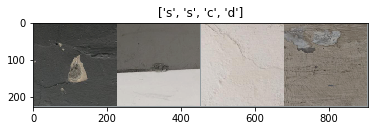

In [12]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.588, 0.618, 0.630])
    std = np.array([0.092, 0.086, 0.086])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated



class_names = dataset.classes
print(class_names)
# Get a batch of training data
inputs, classes = next(iter(train_loader))
inputs2 = inputs [1]
inputs3 = inputs2 [:4]
classes2 = classes[:4]+1

# # Make a grid from batch
out = torchvision.utils.make_grid(inputs3)
imshow(out, title=[class_names[x] for x in classes2])

## Create model

In [13]:
def create_model(ema=False):
        
    model = models.resnet101(pretrained=True)
    num_rs = model.fc.in_features
    model.fc = nn.Linear(num_rs, num_classes)
    model = nn.DataParallel(model).to(device)
                 


    if ema:
        for param in model.parameters():
            param.detach_()  # separate the parameters from the model to not participate the param update
            # teacher model does not require gradient descent

    return model

model = create_model()
ema_model = create_model(ema=True)


LOG.info(parameters_string(model))


List of model parameters:
module.conv1.weight                            64 * 3 * 7 * 7 =       9,408
module.bn1.weight                                          64 =          64
module.bn1.bias                                            64 =          64
module.layer1.0.conv1.weight                  64 * 64 * 1 * 1 =       4,096
module.layer1.0.bn1.weight                                 64 =          64
module.layer1.0.bn1.bias                                   64 =          64
module.layer1.0.conv2.weight                  64 * 64 * 3 * 3 =      36,864
module.layer1.0.bn2.weight                                 64 =          64
module.layer1.0.bn2.bias                                   64 =          64
module.layer1.0.conv3.weight                 256 * 64 * 1 * 1 =      16,384
module.layer1.0.bn3.weight                                256 =         256
module.layer1.0.bn3.bias                                  256 =         256
module.layer1.0.downsample.0.weight          256 * 64 * 1 * 1

## Train & Test

In [14]:
optimizer = torch.optim.SGD(model.parameters(), args.lr,
                            momentum=args.momentum,
                            weight_decay=args.weight_decay,
                            nesterov=args.nesterov)

# optionally resume from a checkpoint
if args.resume:
    assert os.path.isfile(args.resume), "=> no checkpoint found at '{}'".format(args.resume)
    LOG.info("=> loading checkpoint '{}'".format(args.resume))
    checkpoint = torch.load(args.resume)
    args.start_epoch = checkpoint['epoch']
    global_step = checkpoint['global_step']
    best_prec1 = checkpoint['best_prec1']
    model.load_state_dict(checkpoint['state_dict'])
    ema_model.load_state_dict(checkpoint['ema_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    LOG.info("=> loaded checkpoint '{}' (epoch {})".format(args.resume, checkpoint['epoch']))

cudnn.benchmark = True

if args.evaluate:
    LOG.info("Evaluating the primary model:")
    validate(eval_loader, model, validation_log, global_step, args.start_epoch)
    LOG.info("Evaluating the EMA model:")
    validate(eval_loader, ema_model, ema_validation_log, global_step, args.start_epoch)
    
since = time.time()
for epoch in range(args.start_epoch, args.epochs):
    print('Epoch {}/{}'.format(epoch, args.epochs - 1))
    print('-' * 10)    
    
    start_time = time.time()
    # train for one epoch
    train(train_loader, model, ema_model, optimizer, epoch)
    LOG.info("--- training epoch in %s seconds ---" % (time.time() - start_time))

    if args.evaluation_epochs and (epoch + 1) % args.evaluation_epochs == 0:
        start_time = time.time()
        LOG.info("Evaluating the primary model:")
        prec1 = validate(eval_loader, model, validation_log, global_step, epoch + 1)
        LOG.info("Evaluating the EMA model:")
        ema_prec1 = validate(eval_loader, ema_model, ema_validation_log, global_step, epoch + 1)
        LOG.info("--- validation in %s seconds ---" % (time.time() - start_time))
        is_best = ema_prec1 > best_prec1
        best_prec1 = max(ema_prec1, best_prec1)
        
        viz.line([[prec1.cpu().numpy(),ema_prec1.cpu().numpy()]], [epoch], win = 'Test', update = 'append')
        
    else:
        is_best = False

time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(
time_elapsed // 60, time_elapsed % 60))


Epoch 0/19
----------


--- training epoch in 8.883179903030396 seconds ---
Evaluating the primary model:
Evaluating the EMA model:


tensor(42.5743, device='cuda:0')


--- validation in 1.4268901348114014 seconds ---


tensor(36.6337, device='cuda:0')
Epoch 1/19
----------


--- training epoch in 6.613637924194336 seconds ---
Evaluating the primary model:
Evaluating the EMA model:


tensor(66.3366, device='cuda:0')


--- validation in 0.9905657768249512 seconds ---


tensor(60.3960, device='cuda:0')
Epoch 2/19
----------


--- training epoch in 6.6347973346710205 seconds ---
Evaluating the primary model:
Evaluating the EMA model:


tensor(75.2475, device='cuda:0')


--- validation in 0.9985692501068115 seconds ---


tensor(63.3663, device='cuda:0')
Epoch 3/19
----------


--- training epoch in 6.619422912597656 seconds ---
Evaluating the primary model:
Evaluating the EMA model:


tensor(77.2277, device='cuda:0')


--- validation in 0.9749331474304199 seconds ---


tensor(69.3069, device='cuda:0')
Epoch 4/19
----------


--- training epoch in 6.661612272262573 seconds ---
Evaluating the primary model:
Evaluating the EMA model:


tensor(80.1980, device='cuda:0')


--- validation in 0.998222827911377 seconds ---


tensor(70.2970, device='cuda:0')
Epoch 5/19
----------


--- training epoch in 6.6049888134002686 seconds ---
Evaluating the primary model:
Evaluating the EMA model:


tensor(80.1980, device='cuda:0')


--- validation in 1.018735408782959 seconds ---


tensor(77.2277, device='cuda:0')
Epoch 6/19
----------


--- training epoch in 6.635613918304443 seconds ---
Evaluating the primary model:
Evaluating the EMA model:


tensor(76.2376, device='cuda:0')


--- validation in 0.9656050205230713 seconds ---


tensor(74.2574, device='cuda:0')
Epoch 7/19
----------


--- training epoch in 6.625499486923218 seconds ---
Evaluating the primary model:
Evaluating the EMA model:


tensor(79.2079, device='cuda:0')


--- validation in 0.9799118041992188 seconds ---


tensor(77.2277, device='cuda:0')
Epoch 8/19
----------


--- training epoch in 6.6562395095825195 seconds ---
Evaluating the primary model:
Evaluating the EMA model:


tensor(79.2079, device='cuda:0')


--- validation in 1.0050444602966309 seconds ---


tensor(79.2079, device='cuda:0')
Epoch 9/19
----------


--- training epoch in 6.637967109680176 seconds ---
Evaluating the primary model:
Evaluating the EMA model:


tensor(82.1782, device='cuda:0')


--- validation in 0.9921615123748779 seconds ---


tensor(80.1980, device='cuda:0')
Epoch 10/19
----------


--- training epoch in 6.6267712116241455 seconds ---
Evaluating the primary model:
Evaluating the EMA model:


tensor(86.1386, device='cuda:0')


--- validation in 0.972315788269043 seconds ---


tensor(81.1881, device='cuda:0')
Epoch 11/19
----------


--- training epoch in 6.617145299911499 seconds ---
Evaluating the primary model:
Evaluating the EMA model:


tensor(78.2178, device='cuda:0')


--- validation in 0.9655964374542236 seconds ---


tensor(80.1980, device='cuda:0')
Epoch 12/19
----------


--- training epoch in 6.6436028480529785 seconds ---
Evaluating the primary model:
Evaluating the EMA model:


tensor(82.1782, device='cuda:0')


--- validation in 0.9890012741088867 seconds ---


tensor(83.1683, device='cuda:0')
Epoch 13/19
----------


--- training epoch in 6.748420715332031 seconds ---
Evaluating the primary model:
Evaluating the EMA model:


tensor(79.2079, device='cuda:0')


--- validation in 0.9915947914123535 seconds ---


tensor(85.1485, device='cuda:0')
Epoch 14/19
----------


--- training epoch in 6.684987306594849 seconds ---
Evaluating the primary model:
Evaluating the EMA model:


tensor(74.2574, device='cuda:0')


--- validation in 0.9695677757263184 seconds ---


tensor(82.1782, device='cuda:0')
Epoch 15/19
----------


--- training epoch in 6.660938501358032 seconds ---
Evaluating the primary model:
Evaluating the EMA model:


tensor(76.2376, device='cuda:0')


--- validation in 0.9735250473022461 seconds ---


tensor(80.1980, device='cuda:0')
Epoch 16/19
----------


--- training epoch in 6.791191577911377 seconds ---
Evaluating the primary model:
Evaluating the EMA model:


tensor(75.2475, device='cuda:0')


--- validation in 0.9849629402160645 seconds ---


tensor(81.1881, device='cuda:0')
Epoch 17/19
----------


--- training epoch in 6.7010498046875 seconds ---
Evaluating the primary model:
Evaluating the EMA model:


tensor(77.2277, device='cuda:0')


--- validation in 0.9806122779846191 seconds ---


tensor(81.1881, device='cuda:0')
Epoch 18/19
----------


--- training epoch in 6.649392366409302 seconds ---
Evaluating the primary model:
Evaluating the EMA model:


tensor(80.1980, device='cuda:0')


--- validation in 0.9572122097015381 seconds ---


tensor(81.1881, device='cuda:0')
Epoch 19/19
----------


--- training epoch in 6.680346727371216 seconds ---
Evaluating the primary model:
Evaluating the EMA model:


tensor(80.1980, device='cuda:0')


--- validation in 0.9651103019714355 seconds ---


tensor(81.1881, device='cuda:0')
Training complete in 2m 36s


In [15]:
# torch.save(model.state_dict(), '/home/bdggj/Documents/facade_defects/semi-supervised/trained_model/03052020/student')

In [16]:
# torch.save(ema_model.state_dict(), '/home/bdggj/Documents/facade_defects/semi-supervised/trained_model/03052020/teacher')

In [17]:
print(best_prec1)

tensor(85.1485, device='cuda:0')


In [18]:
print(time.time())
print(start_time)

1588514927.9576697
1588514926.9601197
